In [1]:
import pandas as pd
from random import choice
from ord_data_load import ORD_PATH, is_reaction_of_type, df_na_vals
from chem_render import draw_reaction, indigo, draw_reaction_smi
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from time import time

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()

import torch
from rxnmapper import RXNMapper

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


%load_ext autoreload
%autoreload 2

torch.cuda.is_available(), torch.version.__version__

C:\Users\ergot\mambaforge\envs\chem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(True, '1.11.0')

In [2]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

CPU times: total: 3.53 s
Wall time: 3.53 s


In [3]:
%%time
pd_mask = df.notes.str.contains(r'Pd|[Pp]all?ad').fillna(False)
pd_mask.sum()

97225

In [4]:
%%time
pd_df = df[pd_mask]

CPU times: total: 15.6 ms
Wall time: 19 ms


In [79]:
%%time
from rxnmapper import BatchedMapper
batch_mapper = BatchedMapper(batch_size=16, canonicalize=True)

Some weights of the model checkpoint at C:\Users\ergot\mambaforge\envs\chem\lib\site-packages\rxnmapper\models\transformers\albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: total: 15.6 ms
Wall time: 16.8 ms


In [82]:
%%time
res_batch = pd.DataFrame(list(batch_mapper.map_reactions_with_info(pd_df.rxn_smiles)))
res_batch

CPU times: total: 2min 31s
Wall time: 2min 31s


,confidence,rxn_smiles
0,0.915814,CC(=O)O.O=C(OCc1ccccc1)[NH:12][C@H:11]([C:9]([...
1,0.930410,O=C(OCc1ccccc1)[NH:12][C@H:11]([C:9]([NH:8][C@...
2,0.277900,C1COCCO1.Cl.CCN(CC)CC.CC(C)(C)O[C:13]([NH:12][...
3,0.160785,C1C[O:18]CCO1.Cl.CC[N:15](CC)[CH2:14]C.C[C:17]...
4,0.730158,CO.O=C(OCc1ccccc1)[NH:13][C@H:12]([C:10]([NH:9...
...,...,...
9995,0.947489,C1COCCO1.CCO.O.O=[N+]([O-])c1ccc(C[O:3][C:2](=...
9996,0.935826,C1COCCO1.O=[N+]([O-])c1ccc(C[O:13][C:11]([C:10...
9997,0.850569,C1COCCO1.CCO.O=[N+]([O-])c1ccc(C[O:9][C:7]([C:...
9998,0.958907,C=CC[O:11][C:9]([C:8]1=[C:12]([N:13]=[N+:14]=[...


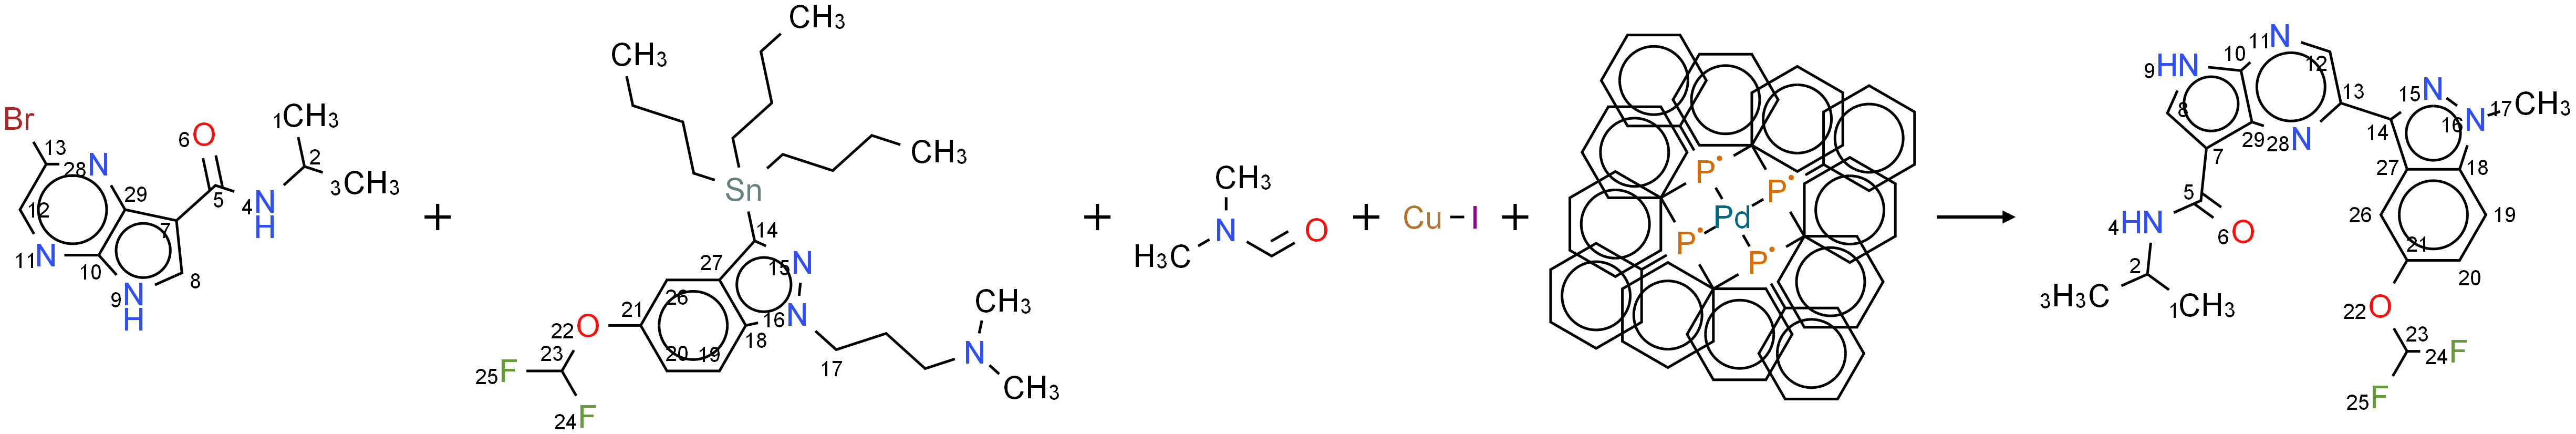

Set size:         10000
Patent:           None
Reaction_id:      7879
None


7879

In [83]:
draw_reaction(res_batch)

In [41]:
pd_df.index.get_loc("ord-ec57be9eb3044d5884323695460dbccf")

0

In [8]:
N = 100
batch_size = 32
results = []
start = time()

for i in range(N):
    print(f"{i * batch_size:5d} / {len(pd_df)}      {time() - start:.1f}s", end="\r")
    pl = batch_size * i
    ph = batch_size * (i + 1)
    results.extend(rxn_mapper.get_attention_guided_atom_maps(pd_df.rxn_smiles[pl:ph]))
    torch.cuda.empty_cache()
len(results)

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1

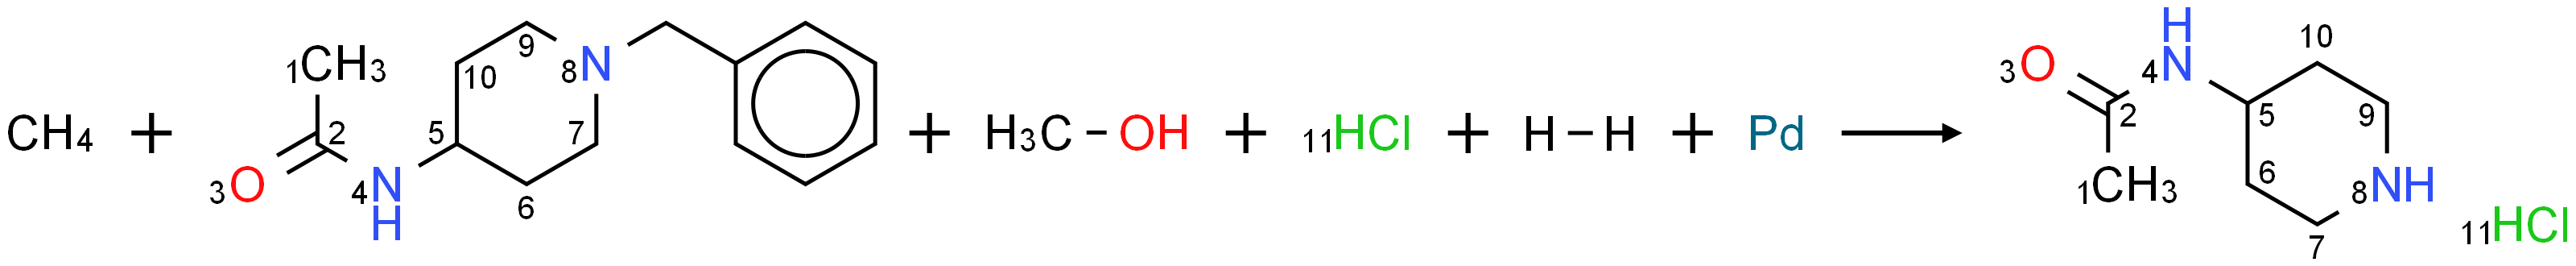

Set size:         100
Patent:           None
Reaction_id:      ord-b74bffc65057435d9d7a9739ada92f3c
None


'ord-b74bffc65057435d9d7a9739ada92f3c'

In [23]:
pd_df.loc[:100, 'rxn_smiles'] = results['rxn_smiles']

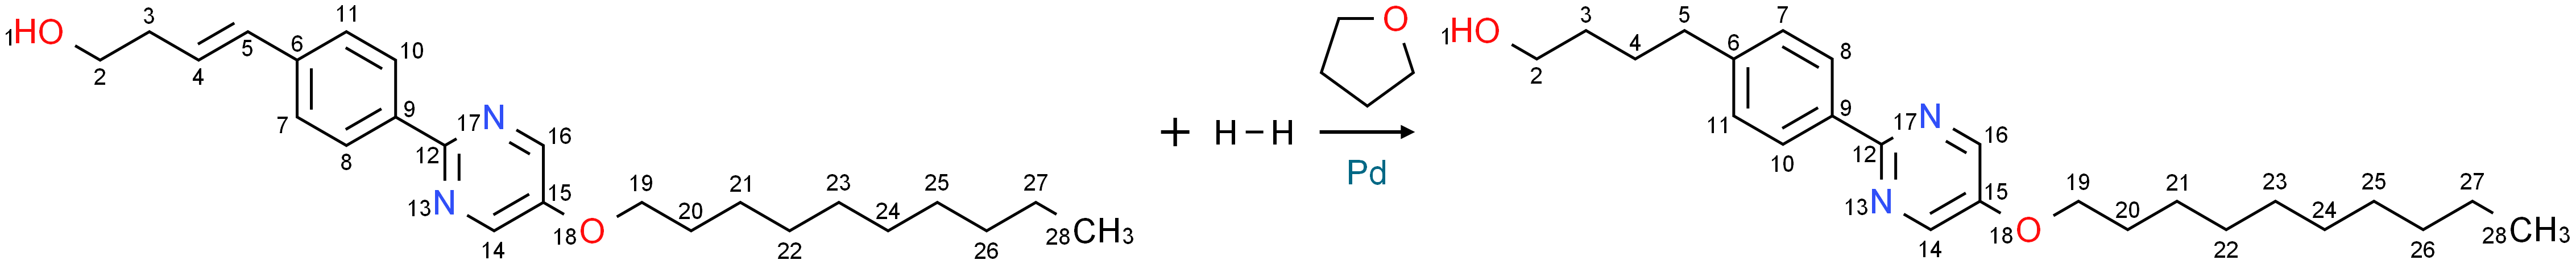

Set size:         100
Patent:           US05723610
Reaction_id:      ord-b9c7d389a33241bbb79d7412a80e13bc
0.38 g (1 mmol) of the thus obtained 2-(4-(4-hydroxy-1-butenyl) phenyl)-5-decyloxypyrimidine was dissolved in 20 ml of tetrahydrofuran, added with 0.05 g of 10% Pd/C and subjected to a hydrogenation reaction in a hydrogen atmosphere under normal pressure. The reaction was stopped when about 25 ml of hydrogen was consumed. Then 10% Pd/C was filtered out and the filtrate was concentrated to obtain 0.38 g of 2-(4-(4-hydroxybutyl)-phenyl)-5-decyloxypyrimidine (yield: 99%).


'ord-b9c7d389a33241bbb79d7412a80e13bc'

In [16]:
draw_reaction(pd_df[:100])

In [8]:
%%time
from rxnmapper import BatchedMapper
batch_mapper = BatchedMapper(batch_size=32)

Some weights of the model checkpoint at C:\Users\ergot\mambaforge\envs\chem\lib\site-packages\rxnmapper\models\transformers\albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: total: 15.6 ms
Wall time: 18.1 ms


In [11]:
%%time
results = list(batch_mapper.map_reactions_with_info(pd_df.rxn_smiles[:5]))
results

CPU times: total: 297 ms
Wall time: 279 ms


[{},
 {},
 {'confidence': 0.19807664816757042,
  'mapped_rxn': '[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH2:7][CH3:8])([CH2:9][CH3:10])[NH:11][C:12]([O:23]C(C)(C)C)=[O:13])[C:20]1=[CH:25][CH:24]=[CH:23][CH:22]=[CH:21]1)[CH3:26].C(N(CC)CC)C.[CH2:15]([CH:14]([C:63]([O-:65])=[O:64])[C@@H:48]([C:16]([O-:18])=[O:17])[NH:19]C(OCC1=CC=CC=C1)=O)C1=CC=CC=C1.O.C1=CC2=C(C=C1)N(O)N=N2.Cl.O1CCOCC1>>[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH2:7][CH3:8])([CH2:9][CH3:10])[NH:11][C:12](=[O:13])[C@H:14]([CH2:15][C:16](=[O:17])[OH:18])[NH2:19])[C:20]1=[CH:25][CH:24]=[CH:23][CH:22]=[CH:21]1)[CH3:26] |f:5.6|'},
 {'confidence': 0.4917998399343566,
  'mapped_rxn': '[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH3:7])([CH2:8][CH3:9])[NH:10][C:11]([O:17][C:15](C)(C)[CH3:14])=[O:12])[C:19]1=[CH:24][CH:23]=[CH:22][CH:21]=[CH:20]1)[CH3:25].[CH2:13]([N:18]([CH2:37]C)CC)C.[OH2:16].Cl.[O:2]1[CH2:7][CH2:6]OCC1>>[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH3:7])([CH2:8][CH3:9])[NH:10][C:11](=[O:12])[C@H:13]([CH2:14][C

In [7]:
results

[{},
 {},
 {'confidence': 0.19807664816757042,
  'mapped_rxn': '[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH2:7][CH3:8])([CH2:9][CH3:10])[NH:11][C:12]([O:23]C(C)(C)C)=[O:13])[C:20]1=[CH:25][CH:24]=[CH:23][CH:22]=[CH:21]1)[CH3:26].C(N(CC)CC)C.[CH2:15]([CH:14]([C:63]([O-:65])=[O:64])[C@@H:48]([C:16]([O-:18])=[O:17])[NH:19]C(OCC1=CC=CC=C1)=O)C1=CC=CC=C1.O.C1=CC2=C(C=C1)N(O)N=N2.Cl.O1CCOCC1>>[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH2:7][CH3:8])([CH2:9][CH3:10])[NH:11][C:12](=[O:13])[C@H:14]([CH2:15][C:16](=[O:17])[OH:18])[NH2:19])[C:20]1=[CH:25][CH:24]=[CH:23][CH:22]=[CH:21]1)[CH3:26] |f:5.6|'},
 {'confidence': 0.4917998399343566,
  'mapped_rxn': '[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH3:7])([CH2:8][CH3:9])[NH:10][C:11]([O:17][C:15](C)(C)[CH3:14])=[O:12])[C:19]1=[CH:24][CH:23]=[CH:22][CH:21]=[CH:20]1)[CH3:25].[CH2:13]([N:18]([CH2:37]C)CC)C.[OH2:16].Cl.[O:2]1[CH2:7][CH2:6]OCC1>>[CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH3:7])([CH2:8][CH3:9])[NH:10][C:11](=[O:12])[C@H:13]([CH2:14][C

In [46]:
res = pd.Series(results)
res

0                                                     >>
1                                                     >>
2      [CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH2:...
3      [CH2:1]([C@H:2]([NH:3][C:4](=[O:5])[C:6]([CH3:...
4                                                     >>
                             ...                        
995                                                   >>
996                                                   >>
997                                                   >>
998                                                   >>
999                                                   >>
Length: 1000, dtype: object

In [55]:
input = pd_df.rxn_smiles[:1000].str.split(" ").str[0].str.replace(r":[1-9][0-9]*", "")
input

C:\Users\ergot\AppData\Local\Temp\ipykernel_11512\1496613276.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  input = pd_df.rxn_smiles[:1000].str.split(" ").str[0].str.replace(r":[1-9][0-9]*", "")


ord-ec57be9eb3044d5884323695460dbccf    [CH2]([C@H]([NH][C](=[O])[C@@H]([C@H]([CH3])[O...
ord-b4a1a9f06c874053b3ad0f85aaa15884    [CH2]([C@H]([NH][C](=[O])[C@@H]([C@@H]([CH2][C...
ord-39d7a85f6c0943d29b102f7ee592196e    Cl.O1CCOCC1.[CH2]([C@H]([NH][C](=[O])[C]([CH2]...
ord-a2a351b69552484f9b0780b4d2a5b2e4    Cl.[O]1[CH2][CH2]OCC1.[CH2]([C@H]([NH][C](=[O]...
ord-1b033c485fa54b2cb55a6e97a581a99c    [CH3][O][CH2][C@H]([NH][C](=[O])[C@@H]([CH]([C...
                                                              ...                        
ord-1456953de32345ee96335a8be154cf74    [CH2]([O][C](=[O])[N]([CH2][CH]=[CH2])[C]1[C](...
ord-6751c4eadf9d473d9245d8a400a12fdc    C(OC([N]1[C]2[C](=[C]3[O][C]([CH]([CH3])[CH3])...
ord-aa5ee3cdfbea4142b6ea9b37f0e14d1e    Br[C]1[C](=[O])[C]2[C](=[C]([N+]([O-])=[O])[C]...
ord-0189d225b5614d789f5d04eee4b24eaf    [NH2][C]1[C]([N+]([O-])=O)=[C]2[C]([C](=[O])[C...
ord-1f7d75009f3e45e8b5f63eb1176a7c1f    [Cl][C]1[CH]=[CH][C]([C]2[C](=[O])[C]3[C](=[C]...
Name: rxn_

In [60]:
%%time
output = list(batch_mapper.map_reactions(input[:100]))
output

NameError: name 'batch_mapper' is not defined

In [59]:
res = pd.Series(output)
(res == '>>').sum()

969

In [57]:
draw_reaction_smi(choice(output))

RuntimeError: CUDA out of memory. Tried to allocate 586.00 MiB (GPU 0; 8.00 GiB total capacity; 7.09 GiB already allocated; 0 bytes free; 7.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [66]:
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

7851737088

In [10]:
torch.cuda.mem_get_info()

(6894387200, 8589475840)

In [11]:
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

6291456